In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


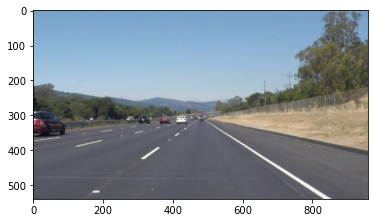

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

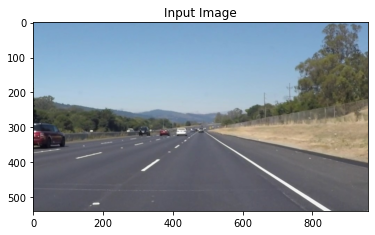

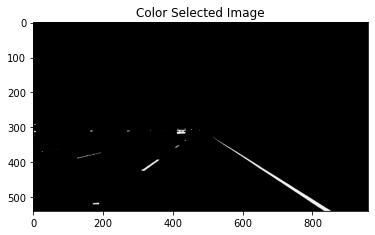

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200
######

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.jpg", color_select)

In [4]:
import math

# Global result variable to track previous result
result = []

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def interpolate_point(point, slope, rows):
    """
    Applies interpolation method for a given point and slope to find the corresponding
    x - co-ordinate for a given y - co-ordinate (rows)
    """
    x = int((rows - point[1]) / slope + point[0])
    return (x,rows)


def draw_lines(img, lines, result, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slope = []
    left_cord = []
    right_slope = []
    right_cord = []
    img_local = np.copy(img)

    # Seperate out left and right lane information using slope value
    for idx, line in enumerate(lines):
        #print('Processing Line {} :'.format(idx))
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1 + np.spacing(1.0))
            if slope <= -0.5 and slope >=-0.8:
                left_slope.append(slope)
                left_cord.append((x1,y1))
                left_cord.append((x2,y2))
            elif slope >= 0.5 and slope <= 0.8:
                right_slope.append(slope)
                right_cord.append((x1,y1))
                right_cord.append((x2,y2))
            else:
                ''
    
    # If the lane is not detected in the current frame, use stored previous frame values
    if len(left_slope) < 1:
        left_slope_avg = result[0]
        left_cord_top = result[1]
        left_cord_bottom = result[2]
    else:
        left_slope_avg = np.average(left_slope)
        left_cord = sorted(left_cord, key=lambda y:y[1])
        left_cord_top = left_cord[0]
        left_cord_bottom = left_cord[-1]
    
    if len(right_slope) < 1:
        right_slope_avg = result[3]
        right_cord_top = result[4]
        right_cord_bottom = result[5]
    else:
        right_slope_avg = np.average(right_slope)
        right_cord = sorted(right_cord, key=lambda y: y[1])
        right_cord_top = right_cord[0]
        right_cord_bottom = right_cord[-1]

    # Based on average slope value, intepolate the line top and bottom points. Here bottom points 
    # is fixed as the image size and top point to somewhere near vanishing point
    left_cord_bottom = interpolate_point(left_cord_bottom,left_slope_avg, img.shape[0] - 1)
    right_cord_bottom = interpolate_point(right_cord_bottom, right_slope_avg, img.shape[0] - 1)
    left_cord_top = interpolate_point(left_cord_top, left_slope_avg, int(img.shape[0]/2 + 80))
    right_cord_top = interpolate_point(right_cord_top, right_slope_avg, int(img.shape[0]/2 + 80))

    # Draw the lines on the image
    cv2.line(img, (left_cord_top), (left_cord_bottom), color, 5)
    cv2.line(img, (right_cord_top), (right_cord_bottom), color, 5)

    # Store the result so that if required can be used in the next frame
    result = [left_slope_avg, left_cord_top, left_cord_bottom, right_slope_avg, right_cord_top, right_cord_bottom]

    return result


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    global result

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    result = draw_lines(line_img, lines, result)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [5]:
def process_img(img):
    
    # Challenge extra video input is of higher resolution. Resize it sp that there iscommon frame work for all the test 
    # videos and images
    if img.shape[0] > 540:
        img = cv2.resize(img,(960,540))
    
    # Convert image tp HSV space. This is helpful in detecing lanes in brighter condition.
    # In HSV only saturation part of the image is used/
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img_saturation = img_hsv[:,:,2]
    
    # convert image into gray scale
    img_gray = grayscale(img)
    
    # Gauss smooth
    img_smooth = gaussian_blur(img_gray, 5)
    img_s_smooth = gaussian_blur(img_saturation, 5)
    
    # Canny Edge
    img_edge = canny(img_smooth, 100, 150)
    img_s_edge = canny(img_s_smooth, 150, 200)
    img_edge = cv2.bitwise_or(img_edge,img_s_edge)
    
    # Constants used in vertices
    imshape = img_gray.shape
    offset_y = 50
    offset_x = 20
    
    # Vanishing point
    vpy = imshape[0]/2 + 60
    
    # Vertices
    vertices = np.array(
        [[(120, imshape[0]-offset_y), ((imshape[1] / 2) - offset_x, vpy), ((imshape[1] / 2) + offset_x, vpy), (900, imshape[0]-offset_y)]],
        dtype=np.int32)
    
    # Create region of interest
    img_mask = region_of_interest(img_edge, vertices)

    # Parameters for hough line
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10   #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    
    # Find lines and process it to find best possible lane location
    img_lines = hough_lines(img_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Overlay the detected lanes above the input image 
    img_output = weighted_img(img_lines, img)
    
    return img_output

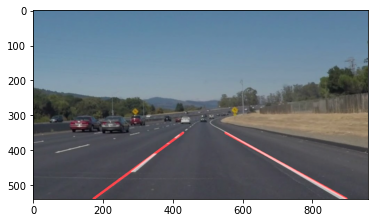

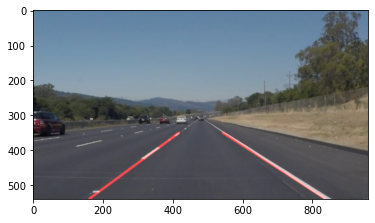

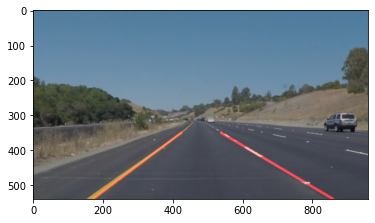

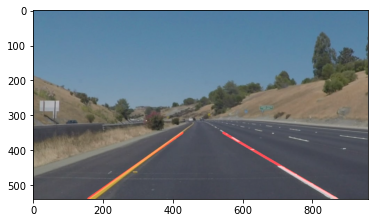

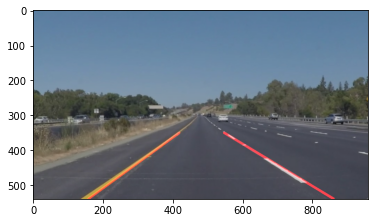

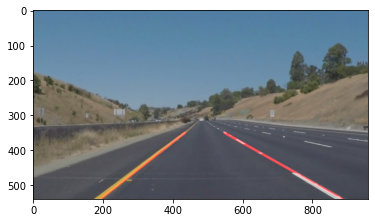

In [6]:
import os

for file_name in os.listdir("test_images/"):
    file_path = os.path.join("test_images", file_name)
    image = mpimg.imread(file_path)
    image = process_img(image)
    plt.imshow(image)
    plt.show()

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = process_img(image)
    return result

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|█▏                                                                   | 4/221 [00:00<00:05, 36.39it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 7.75 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|▏                                                                    | 2/681 [00:00<00:47, 14.43it/s, now=None]

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4



Moviepy - Done !
Moviepy - video ready yellow.mp4
Wall time: 22.5 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|▌                                                                    | 2/251 [00:00<00:18, 13.55it/s, now=None]

Moviepy - Building video extra.mp4.
Moviepy - Writing video extra.mp4



Moviepy - Done !
Moviepy - video ready extra.mp4
Wall time: 11.6 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))